In [5]:
library(deSolve)

In [1]:
simulate <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    om <- 2*pi/365
    dP <- gamma*(1+sin(om*t))*P - lambda*P^2
    list(c(dP))
  })
}

In [2]:
loglike <- function(theta,obs)
{
  # step 1: run the model given the parameters to get state
  tobs <- obs[,1]
  yobs <- obs[,2]
  state <- c(P = 2.5)
  out <- ode(y = state, times = tobs, func = simulate, parms = theta)
  time <- out[,1]
  xhat <- out[,2]  
  # step 2: compute the likelihood ( compare state to observations)
  L <- -sum((yobs-xhat)^2)
}

In [3]:
###########
# load in some (synthetic) observations

load("obs.RData") # contains tobs, yobs
obs <- cbind(tobs,yobs)


In [6]:
############
# The M-H MCMC algorithm

# setup
nc        <- 1000 # number of iterations (length of the chain)
theta_acc <- array(NA,dim=c(nc,2)) # accumulator for sample (parameter posterior)

thetaold  <- c(.2, .1) # initial condition for chain (parameter values)

# priors (use uniforms so set upper and lower bounds)
gam_low   <- .2
gam_up    <- .3
lam_low   <- .09
lam_up    <- .11

for (ic in 1:nc){

    # ** Step 1: Generate Trial Candidate (draw from parameter prior)
    gammac <- runif(1,gam_low, gam_up)
    lambdac <- runif(1,lam_low,lam_up)
    thetac <- c(gammac,lambdac)

    # Step 2: Compute acceptance probability for this candidate
    # compute log likelihood for candidate
    like_num <- loglike(c(gamma=thetac[1],lambda=thetac[2]),obs)

    # compute log likelihood for last member of chain (last sample member)
    like_denom <- loglike(c(gamma=thetaold[1],lambda=thetaold[2]),obs)

    # compute the likehihood ratio
    likeratio=exp(like_num - like_denom)

    # determine acceptance probability
    A=min(c(1,likeratio)); 

    # Step 3: Choose whether or not to accept candidate
    # accept candidate with probability A, otherwise revert to previous chain member
    u=runif(1,0,1)
    if (u<=A) {thetanew <- thetac} else {thetanew <- thetaold}

    # add to the sample 
    theta_acc[ic,] <- thetanew
    thetaold <- thetanew
} 


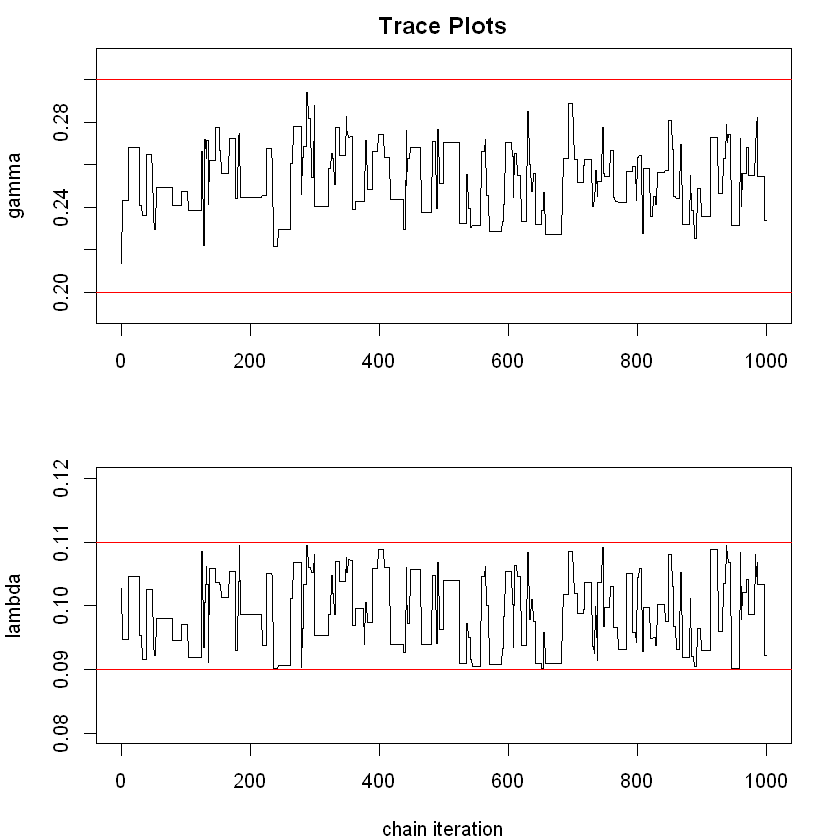

In [10]:
##################
# plot the results

# trace plots
par(mfrow=c(2,1),mar=c(4,4,2,2))
offset <- 0.01
plot(theta_acc[,1], type="l", main="Trace Plots", ylab="gamma", xlab="", ylim=c(gam_low-offset,gam_up+offset))
abline(h=c(gam_low,gam_up), col="red")
plot(theta_acc[,2], type="l", xlab="chain iteration", ylab="lambda", ylim=c(lam_low-offset,lam_up+offset))
abline(h=c(lam_low,lam_up), col="red")


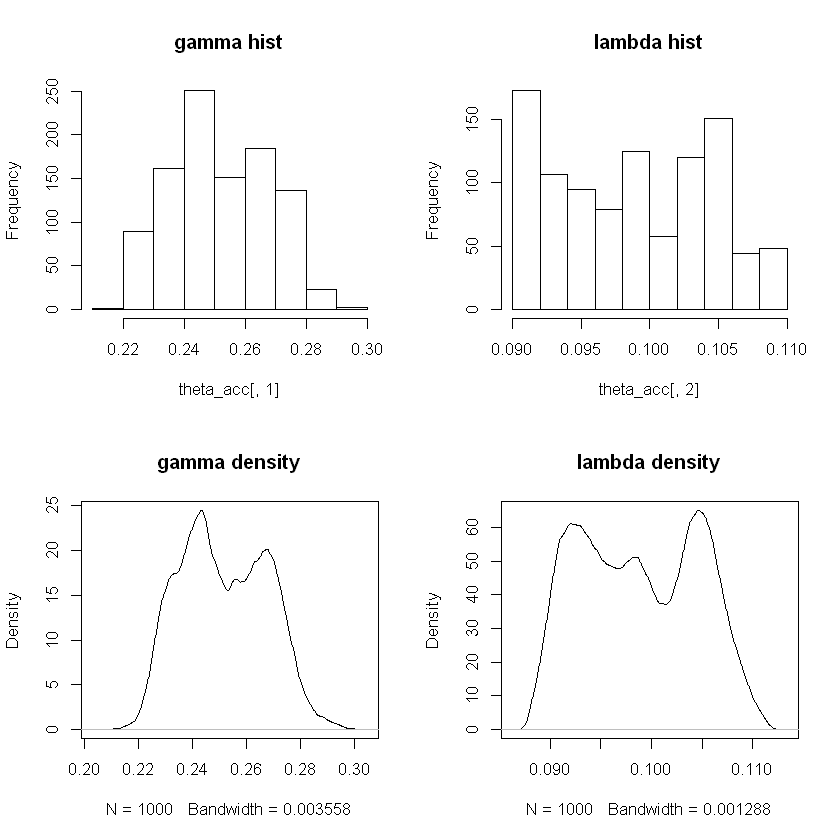

In [11]:
# histogram and kernel smooth density of posterior
par(mfrow=c(2,2))
hist(theta_acc[,1], main="gamma hist")
hist(theta_acc[,2], main="lambda hist")
ksd_gam <- density(theta_acc[,1], kernel="triangular")
plot(ksd_gam, main="gamma density")
ksd_lam <- density(theta_acc[,2], kernel="triangular")
plot(ksd_lam, main="lambda density" )

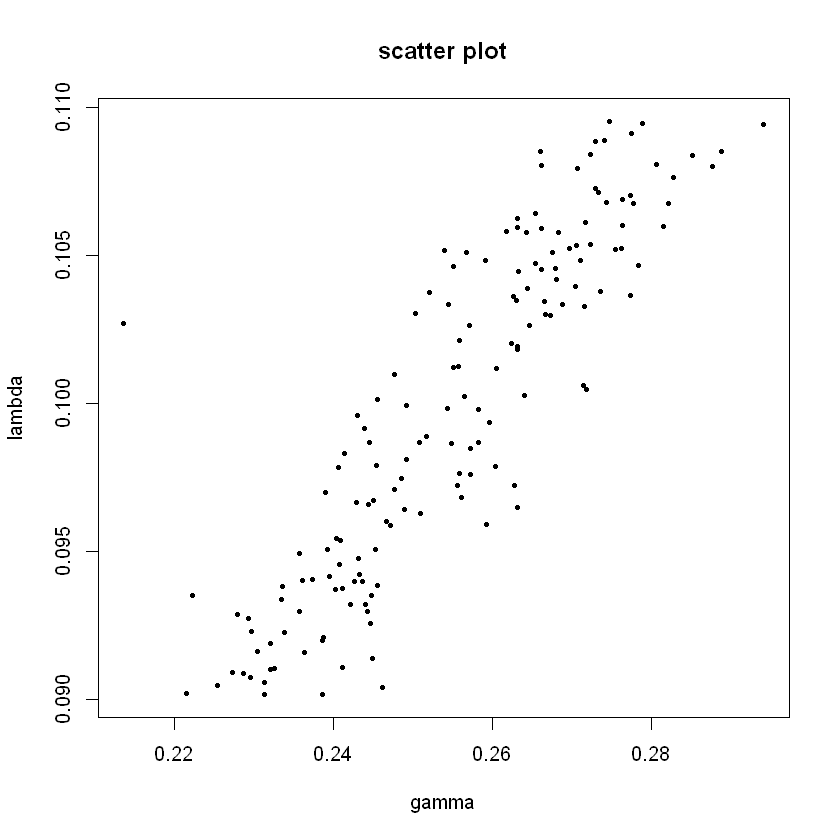

In [12]:
# scatter plots of joint distribution
par(mfrow=c(1,1))
plot(theta_acc[,1], theta_acc[,2],type="p", 
     pch=19, cex=0.5, col="black", xlab="gamma", ylab="lambda", main="scatter plot")